## Task C

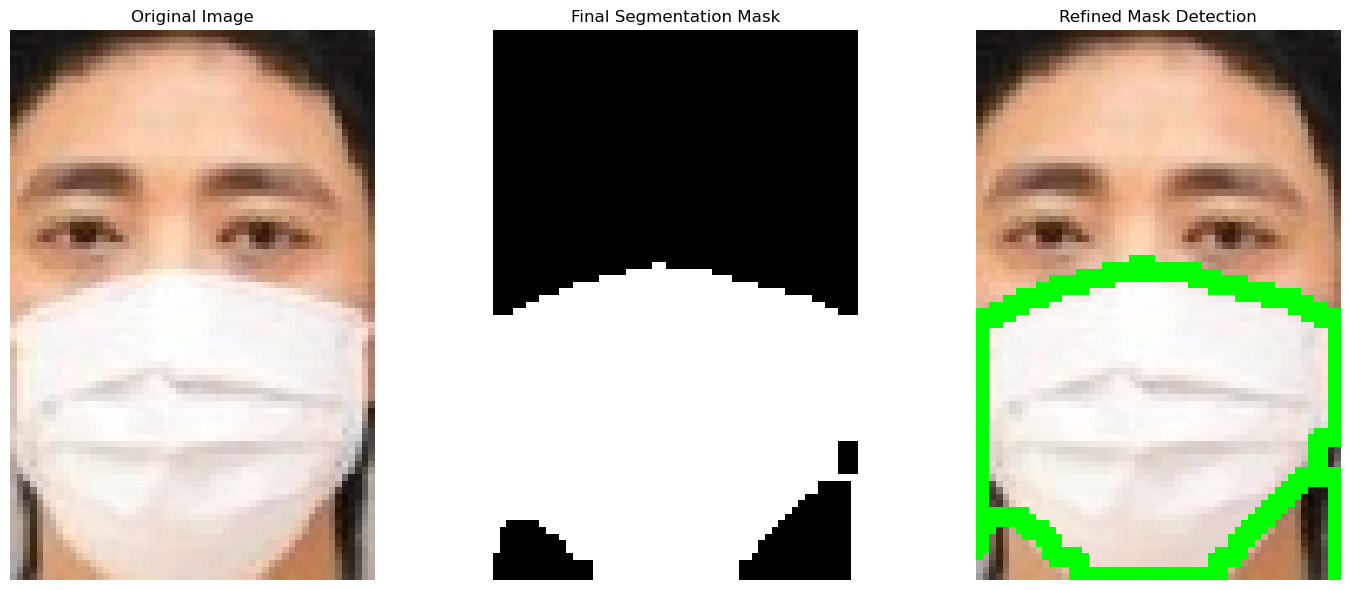

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image_path = "dataset/with_mask/0_0_663d85a4jw6dd814u9pyfj.jpg"
image = cv2.imread(image_path)


gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Otsu's thresholding
_, binary_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Convert to HSV for color segmentation
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower_white = np.array([0, 0, 180])   
upper_white = np.array([180, 50, 255]) 
mask = cv2.inRange(hsv, lower_white, upper_white)


combined = cv2.bitwise_and(binary_thresh, mask)

# Apply morphological operations to refine the mask
kernel = np.ones((3, 3), np.uint8)
closed = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel, iterations=2)


contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


min_contour_area = 1000  
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

output = image.copy()
cv2.drawContours(output, filtered_contours, -1, (0, 255, 0), 2)

# Visualization
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(closed, cmap="gray")
plt.title("Final Segmentation Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Refined Mask Detection")
plt.axis("off")

plt.tight_layout()
plt.show()


## Task D

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [ ]:
masked_path = "MSFD/1/face_crop"
unmasked_path = "MSFD/1/face_crop_segmentation"

In [ ]:

def load_images(path,gray):
    images = []
    for filename in os.listdir(path):
        img_path = path + "/" + filename
        if gray:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img,(128,128)) 
        images.append(img)
    
    return images

In [ ]:

masked_images = load_images(masked_path,0)
segmented_images = load_images(unmasked_path,1)


In [ ]:
X = np.array(masked_images)
Y = np.array(segmented_images)

In [ ]:
Y.shape

(9383, 128, 128)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.

In [ ]:
# Normalize Y_train and Y_val to be 0 or 1
Y_train = (Y_train >= 128).astype('float32')  # Convert to 1 if greater than or equal to 128, else 0
Y_val = (Y_val >= 128).astype('float32')  # Same for validation labels

In [ ]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))  # 2D input (height, width, channels)
    
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c9)

    # Output layer for binary segmentation (1 class)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)  # 1 class (binary segmentation)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()
    
    return model


In [ ]:
model = simple_unet_model(128, 128, 3) 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0]  

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


In [ ]:


history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=25,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]  # Pass early stopping callback
)

Epoch 1/25


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


235/235 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.7646 - loss: 0.4562 - val_accuracy: 0.8776 - val_loss: 0.3017
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.8806 - loss: 0.2792 - val_accuracy: 0.8808 - val_loss: 0.2797
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 449s 2s/step - accuracy: 0.8814 - loss: 0.2764 - val_accuracy: 0.8826 - val_loss: 0.2754
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.8822 - loss: 0.2747 - val_accuracy: 0.8834 - val_loss: 0.2763
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 474s 2s/step - accuracy: 0.8839 - loss: 0.2707 - val_accuracy: 0.8843 - val_loss: 0.2933
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - accuracy: 0.8827 - loss: 0.2717 - val_accuracy: 0.8852 - val_loss: 0.2670
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.8856 - loss: 0.2652 - val_accuracy: 0.8848 - val_loss: 0.2662
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.8859 - loss: 0.2650 - val_accuracy: 0.885

In [ ]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Train Accuracy: {train_accuracy:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

Final Train Accuracy: 0.8865
Final Validation Accuracy: 0.8860


In [ ]:

img = np.expand_dims(X_train[0], axis=0)
predictions = model.predict(img)

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step


In [ ]:
predictions.shape

(1, 128, 128, 1)

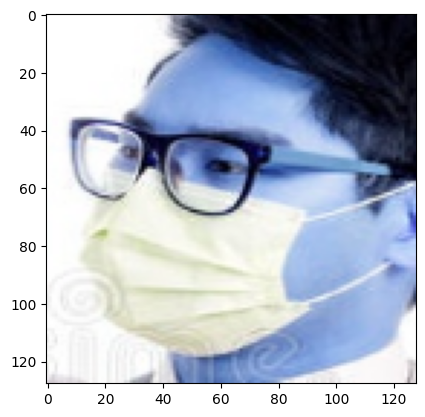

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])


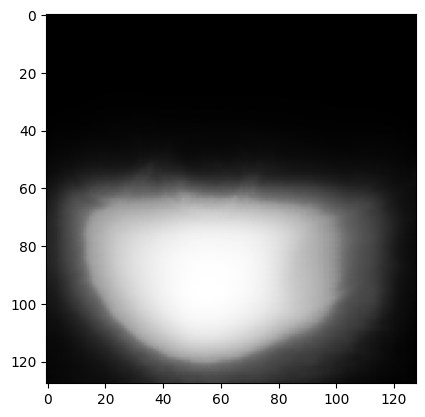

In [ ]:
plt.imshow(predictions[0],cmap='gray')

In [ ]:
model.save('saved_unet_model.keras')

In [ ]:
loaded_model = tf.keras.models.load_model('saved_unet_model.keras')

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
loaded_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0]  

 Total params: 3,882,212 (14.81 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,941,107 (7.40 MB)

In [ ]:
import numpy as np
import tensorflow as tf

def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred, axis=(1, 2))
    union = np.sum(y_true, axis=(1, 2)) + np.sum(y_pred, axis=(1, 2)) - intersection
    return (intersection + smooth) / (union + smooth)

Y_pred = model.predict(np.array(X))
Y_pred = np.squeeze(Y_pred, axis=-1)
Y_pred = (Y_pred > 0.5).astype(np.uint8)

# Compute IoU scores
iou_scores = iou_score(Y, Y_pred)

print("IoU Scores for Test Images:", iou_scores)
print("Mean IoU:", np.mean(iou_scores))


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


294/294 ━━━━━━━━━━━━━━━━━━━━ 98s 331ms/step
IoU Scores for Test Images: [3.82717746 3.01199972 1.14559938 ... 0.68630037 1.95819629 0.42590332]
Mean IoU: 8.222980174653404
